In [ ]:
import ee
import numpy as np
import pandas as pd
import random

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path_drive = r'drive/MyDrive/CropLand/'

Mounted at /content/drive/


In [ ]:
train = pd.read_csv(path_drive + 'Train.csv')
test = pd.read_csv(path_drive + 'Test.csv')
sample_submission = pd.read_csv(path_drive + 'SampleSubmission.csv')

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=M2O7ZTImH9E-fGfEitMFRUtjtc4AY6zoAUh37JD36ig&tc=Prhr7Y-XesEE7f5B0sdx74m3Hfhd1ojk7obDYB3e7dQ&cc=rr1r3aavRYzY35IJwTZjkdfXHM_Wr9Jl62v9FH5SsVk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXkyi_WnVqdLY0tHpoJ0oZtEk3Lq3Kwl1EE35Sy-neLPeTtNUTbMImo

Successfully saved authorization token.


# Countries

In [ ]:
#create country boundries

worldBorders = ee.FeatureCollection( 'USDOS/LSIB_SIMPLE/2017' )
iranFilter = ee.Filter.eq( 'country_na', 'Iran' )
afgFilter = ee.Filter.eq('country_na', 'Afghanistan')
sudanFilter = ee.Filter.eq('country_na', 'Sudan')

swissFilter = ee.Filter.eq('country_na', 'Switzerland')

iranRegion = worldBorders.filter( iranFilter )
afgRegion = worldBorders.filter( afgFilter )
sudanRegion = worldBorders.filter( sudanFilter )
swissRegion = worldBorders.filter(swissFilter)



In [ ]:
!pip install geemap
import geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


In [ ]:
Map = geemap.Map()
Map.addLayer(iranRegion)
Map.addLayer(sudanRegion)
Map.addLayer(afgRegion)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
#define time periods
time_periods_train = {}
time_periods_train['Iran'] = ('2019-07-01', '2020-06-30')
time_periods_train['Sudan'] = ('2019-07-01', '2020-06-30')
time_periods_train['Afghanistan'] = ('2022-04-01', '2022-04-30')

time_periods_test = {}
time_periods_test['Iran'] = ('2019-07-01', '2020-06-30')
time_periods_test['Sudan'] = ('2019-07-01', '2020-06-30')
time_periods_test['Afghanistan'] = ('2022-04-01', '2022-04-30')

In [ ]:
#label each point to a country

def label_country(row):

    lat = row['Lat']
    lon = row['Lon']

    # hardcode based on lon
    value = 'None'

    if lon > 70 and lon < 71:

      value = 'Afghanistan'

    elif lon > 48 and lon < 49:

      value = 'Iran'

    elif lon > 33 and lon < 34:

      value = 'Sudan'

    else:
      value = 'None'

      print("Some error occured")

    return value

train_data = train.copy()

countries = train_data.apply(label_country, axis = 1)

train_data['country'] = countries


train_data['country'].value_counts()

Afghanistan    500
Iran           500
Sudan          500
Name: country, dtype: int64

In [ ]:
test_data = test.copy()
countries = test_data.apply(label_country, axis = 1)
test_data['country'] = countries
test_data['country'].value_counts()

Afghanistan    500
Iran           500
Sudan          500
Name: country, dtype: int64

# Sentinel 2 Data

In [ ]:
def get_features_sentinel2(time_series, list_of_band):

  df = pd.DataFrame(time_series)

  header = df.iloc[0]

  df = pd.DataFrame(df.values[1:], columns=header)

  df = df[['longitude', 'latitude', 'time', *list_of_band]].dropna()

  df = df[df['MSK_CLDPRB'] < 5] #drop all values where the probability of a cloud is greater or equal than 5%

  df['datetime'] = pd.to_datetime(df['time'], unit='ms')


  #calculate ndvi_median and change over the time period
  ndvi_arr = (df['B8'] - df['B4']) / (df['B8'] + df['B4']) #calc NDVI
  ndvi_med = ndvi_arr.quantile(0.5)
  ndvi_change = ndvi_arr.quantile(0.9) - ndvi_arr.quantile(0.1)

  #calc NDWI
  ndwi_arr = (df['B8'] - df['B11']) / (df['B8'] + df['B11'])
  ndwi_med = ndwi_arr.quantile(0.5)
  ndwi_change = ndwi_arr.quantile(0.9) - ndwi_arr.quantile(0.1)

  # red edge Normalized Difference Vegetation Index RENDVI
  rendvi_arr = (df['B8A'] - df['B6']) / (df['B8A'] + df['B6'])
  rendvi_med = rendvi_arr.quantile(0.5)
  rendvi_change = rendvi_arr.quantile(0.9) - rendvi_arr.quantile(0.1)

  # Bare soil index
  bi_arr = ((df['B11']+df['B4']) - (df['B8'] + df['B2'])) / ((df['B11']+df['B4']) + (df['B8'] + df['B2']))
  bi_med = bi_arr.quantile(0.5)
  bi_change = bi_arr.quantile(0.9) - bi_arr.quantile(0.1)

  # Normalized Difference Moisture Index (NDMI)
  ndmi_arr = (df['B8']- df['B11']) / (df['B8']+ df['B11'])
  ndmi_med = ndmi_arr.quantile(0.5)
  ndmi_change = ndmi_arr.quantile(0.9) - ndmi_arr.quantile(0.1)

  # ratio B7 over B6
  sr = df['B7'] / df['B8']
  sr_med = sr.quantile(0.5)
  sr_change = sr.quantile(0.9)- sr.quantile(0.1)

  #bands
  b2_med = df['B2'].quantile(0.5)
  b3_med = df['B3'].quantile(0.5)
  b4_med = df['B4'].quantile(0.5)


  return [ndvi_change, ndwi_change, rendvi_change, bi_change, ndmi_change, sr_change,
          ndvi_med, ndwi_med, rendvi_med, bi_med, ndmi_med, sr_med,  b2_med, b3_med, b4_med]


In [ ]:
CLOUD_FILTER = 10 # for filtering the pixels

s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

s2_bands = ['B2', 'B3', 'B4' , 'B6', 'B7', 'B8', 'B8A',  'B11', 'MSK_CLDPRB']

def extract_sentinel2_data(row, time_windows, train_bool):

  lat = row['Lat']
  lon = row['Lon']

  country = row['country']

  point = ee.Geometry.Point(lon, lat)

  time_period = time_windows[country]

  if country == 'Iran' or country == 'Sudan':

    s2_filtered = s2_collection.filterBounds(point).filterDate(time_period[0], time_period[1])

    values = s2_filtered.getRegion(point, 10).getInfo()

    features = get_features_sentinel2(values, list_of_band= s2_bands)

  else:
    #month where we have values, afgahnistan only period for 1 month
    s2_filtered_month = s2_collection.filterBounds(point).filterDate(time_period[0], time_period[1])
    values_month = s2_filtered_month.getRegion(point, 10).getInfo()
    features_month = get_features_sentinel2(values_month, list_of_band= s2_bands)
    #whole year befor this month
    if train_bool:
      s2_filtered_year =  s2_collection.filterBounds(point).filterDate('2021-04-30', '2022-04-30')
    else:
      s2_filtered_year =  s2_collection.filterBounds(point).filterDate('2021-04-30', '2022-04-30')

    values_year = s2_filtered_year.getRegion(point, 10).getInfo()
    features_year = get_features_sentinel2(values_year, list_of_band = s2_bands)

    features_month[:6] = features_year[:6]
    features = features_month

  return features





In [ ]:
features_sentinel2 = train_data.apply(extract_sentinel2_data,
                                      time_windows = time_periods_train, train_bool = True,
                                      axis=1, result_type='expand')
features_sentinel2.columns = ['NDVI_change', 'NDWI_change', 'RNDVI_change', 'BI_change', 'NDMI_change', 'SR_change',
                              'NDVI', 'NDWI', 'RNDVI', 'BI', 'NDMI', 'SR',  'B2', 'B3', 'B4']
train_data = pd.concat([train_data, features_sentinel2], axis=1)

KeyboardInterrupt: ignored

In [ ]:
test_sentinel2 = test_data.apply(extract_sentinel2_data, time_windows = time_periods_test, train_bool = False,
                                 axis = 1, result_type = 'expand' )
test_sentinel2.columns = ['NDVI_change', 'NDWI_change', 'RNDVI_change', 'BI_change', 'NDMI_change', 'SR_change',
                              'NDVI', 'NDWI', 'RNDVI', 'BI', 'NDMI', 'SR',  'B2', 'B3', 'B4']
test_data = pd.concat([test_data, test_sentinel2], axis = 1)

In [ ]:
train_data.head()

In [ ]:
train_data.to_csv(path_drive +'train_data_senitnel2.csv', index = False)

In [ ]:
test_data.to_csv(path_drive + 'test_data_sentinel2.csv', index = False)

# Sentinel 1 DATA

In [ ]:
def get_features_sentinel1(time_series,  list_of_band):

  df = pd.DataFrame(time_series)

  header = df.iloc[0]

  df = pd.DataFrame(df.values[1:], columns=header)

  df = df[['longitude', 'latitude', 'time', *list_of_band]].dropna()

  df['datetime'] = pd.to_datetime(df['time'], unit='ms')

  VV_arr = df['VV']
  VV_med = VV_arr.quantile(0.5)
  VV_change = VV_arr.quantile(0.9) - VV_arr.quantile(0.1)

  VH_arr = df['VH']
  VH_med = VH_arr.quantile(0.5)
  VH_change = VH_arr.quantile(0.9) - VH_arr.quantile(0.1)

  VH_VV_arr = df['VH']/df['VV']
  VH_VV_med = VH_VV_arr.quantile(0.5)
  VH_VV_change = VH_VV_arr.quantile(0.9) - VH_VV_arr.quantile(0.1)

  VV_plus_VH_arr = df['VV'] + df['VH']
  VV_plus_VH_med = VV_plus_VH_arr.quantile(0.5)
  VV_plus_VH_change = VV_plus_VH_arr.quantile(0.9) - VV_plus_VH_arr.quantile(0.1)

  return [VV_change, VH_change, VH_VV_change, VV_plus_VH_change, VV_med, VH_med, VH_VV_med, VV_plus_VH_med]



In [ ]:

s1_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
        .filter(ee.Filter.eq('instrumentMode', 'IW')))

s1_asc = s1_collection.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
s1_des = s1_collection.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

s1_bands = ['VV', 'VH']

def extract_sentinel1_data(row , time_windows, train_bool):
  lat = row['Lat']
  lon = row['Lon']

  country = row['country']

  point = ee.Geometry.Point(lon, lat)

  time_period = time_windows[country]

  if country == 'Iran' or country == 'Sudan':

    s1_filtered_asc = s1_asc.filterBounds(point).filterDate(time_period[0], time_period[1])
    s1_filtered_des = s1_des.filterBounds(point).filterDate(time_period[0], time_period[1])

    values_asc = s1_filtered_asc.getRegion(point, 10).getInfo()
    values_des = s1_filtered_des.getRegion(point, 10).getInfo()



    features_asc = get_features_sentinel1(values_asc, list_of_band= s1_bands)
    features_des = get_features_sentinel1(values_des, list_of_band= s1_bands)



  else:
    #month where we have values, afgahnistan only period for 1 month
    s1_filtered_month_asc = s1_asc.filterBounds(point).filterDate(time_period[0], time_period[1])
    values_month_asc = s1_filtered_month_asc.getRegion(point, 10).getInfo()
    features_month_asc = get_features_sentinel1(values_month_asc , list_of_band= s1_bands)

    s1_filtered_month_des = s1_des.filterBounds(point).filterDate(time_period[0], time_period[1])
    values_month_des = s1_filtered_month_des.getRegion(point, 10).getInfo()
    features_month_des = get_features_sentinel1(values_month_des , list_of_band= s1_bands)



    #whole year befor this month
    if train_bool:
      s1_filtered_year_asc =  s1_asc.filterBounds(point).filterDate('2021-04-30', '2022-04-30')
      s1_filtered_year_des =  s1_des.filterBounds(point).filterDate('2021-04-30', '2022-04-30')

    else:
      s1_filtered_year_asc =  s1_asc.filterBounds(point).filterDate('2021-04-30', '2022-04-30')
      s1_filtered_year_des =  s1_des.filterBounds(point).filterDate('2021-04-30', '2022-04-30')

    values_year_asc = s1_filtered_year_asc.getRegion(point, 10).getInfo()
    features_year_asc = get_features_sentinel1(values_year_asc, list_of_band = s1_bands)

    values_year_des = s1_filtered_year_des.getRegion(point, 10).getInfo()
    features_year_des = get_features_sentinel1(values_year_des, list_of_band = s1_bands)



    features_month_asc[:4] = features_year_asc[:4]
    features_month_des[:4] = features_year_des[:4]

    features_asc = features_month_asc
    features_des = features_month_des

  return features_asc + features_des


In [ ]:
features_sentinel1 = train_data.apply(extract_sentinel1_data,
                                      time_windows = time_periods_train, train_bool = True,
                                      axis=1, result_type='expand')
features_sentinel1.columns = ['VV_change_asc', 'VH_change_asc', 'VH/VH_change_asc', 'VV+VH_change_asc', 'VV_asc', 'VH_asc', 'VH/VH_asc', 'VV+VH_asc',
                              'VV_change_des', 'VH_change_des', 'VH/VH_change_des', 'VV+VH_change_des', 'VV_des', 'VH_des', 'VH/VH_des', 'VV+VH_des']
train_data = pd.concat([train_data, features_sentinel1], axis=1)

In [ ]:
train_data.to_csv(path_drive + 'train_sen1_sen2.csv', index = False)

In [ ]:
train_data.head

<bound method NDFrame.head of                    ID        Lat        Lon  Target      country  NDVI_change  \
0     ID_SJ098E7S2SY9  34.162491  70.763668       0  Afghanistan     0.086944   
1     ID_CWCD60FGJJYY  32.075695  48.492047       0         Iran     0.583413   
2     ID_R1XF70RMVGL3  14.542826  33.313483       1        Sudan     0.609774   
3     ID_0ZBIDY0PEBVO  14.359480  33.284108       1        Sudan     0.547860   
4     ID_C20R2C0AYIT0  14.419128  33.528450       0        Sudan     0.080143   
...               ...        ...        ...     ...          ...          ...   
1495  ID_T3WAJGS3B84X  34.292702  70.404578       0  Afghanistan     0.065151   
1496  ID_Q31SWRW623Y8  32.105698  48.294867       1         Iran     0.843492   
1497  ID_O2KBC7HPNOAQ  32.235685  48.185542       0         Iran     0.162928   
1498  ID_8VNTHGHLSUNI  14.329207  33.253206       0        Sudan     0.103316   
1499  ID_C5ACHNL98VTX  14.179817  33.179275       0        Sudan     0.226849  

In [ ]:
test_sentinel1 = test_data.apply(extract_sentinel1_data, time_windows = time_periods_test, train_bool = False,
                                 axis = 1, result_type = 'expand' )
test_sentinel1.columns = ['VV_change_asc', 'VH_change_asc', 'VH/VH_change_asc', 'VV+VH_change_asc', 'VV_asc', 'VH_asc', 'VH/VH_asc', 'VV+VH_asc',
                              'VV_change_des', 'VH_change_des', 'VH/VH_change_des', 'VV+VH_change_des', 'VV_des', 'VH_des', 'VH/VH_des', 'VV+VH_des']
test_data = pd.concat([test_data, test_sentinel1], axis = 1)

test_data.to_csv(path_drive + 'test_sen1_sen2.csv', index = False)

# ML Model

In [ ]:
#import data from sent1 and sent2 -> via csv saved from before or let section Sentinel2 and Sentinel 1 run

train_data = pd.read_csv(path_drive + 'train_sen1_sen2.csv')
test_data = pd.read_csv(path_drive + 'test_sen1_sen2.csv')

In [ ]:
train_data.columns
#s1 from index 20


Index(['ID', 'Lat', 'Lon', 'Target', 'country', 'NDVI_change', 'NDWI_change',
       'RNDVI_change', 'BI_change', 'NDMI_change', 'SR_change', 'NDVI', 'NDWI',
       'RNDVI', 'BI', 'NDMI', 'SR', 'B2', 'B3', 'B4', 'VV_change_asc',
       'VH_change_asc', 'VH/VH_change_asc', 'VV+VH_change_asc', 'VV_asc',
       'VH_asc', 'VH/VH_asc', 'VV+VH_asc', 'VV_change_des', 'VH_change_des',
       'VH/VH_change_des', 'VV+VH_change_des', 'VV_des', 'VH_des', 'VH/VH_des',
       'VV+VH_des'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# Modelling
# Selecting the independent variables and the target variable
X = train_data.drop(['ID', 'Target', 'country'], axis = 1).fillna(0)
y = train_data.Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

X_train_s1 = X_train[X_train.columns[17:]].copy()
X_train_s2 = X_train[X_train.columns[:17]].copy()

X_test_s1 = X_test[X_train.columns[17:]].copy()
X_test_s2 = X_test[X_train.columns[:17]].copy()


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

scaler.transform(X_train)
scaler.transform(X_test)

array([[ 0.60942909, -0.15567936,  1.57197936, ...,  0.33817427,
        -0.1118887 ,  0.17145747],
       [ 0.80958432,  1.31004711, -1.26341451, ..., -0.41384132,
         0.14046135, -0.3012106 ],
       [-1.38204957, -1.11614   , -1.32057643, ...,  1.10876684,
        -0.4919239 ,  0.71352351],
       ...,
       [-1.3850508 , -1.13589558,  0.43144668, ...,  0.45227546,
        -0.28211742,  0.13471531],
       [ 0.59052099, -0.151428  ,  1.62927122, ...,  1.23627858,
        -0.1352037 ,  1.13527318],
       [ 0.83068218,  1.29113237, -0.54692516, ..., -1.36741396,
        -0.17375182, -1.54454051]])

In [ ]:


# A parameter grid for XGBoost
params = {
        'n_estimators': [400, 500, 600, 700, 800],
        'learning_rate': [ 0.01, 0.005, 0.001, 0.0005],
        'min_child_weight': [1],
        'gamma': [0.8, 1, 1.2],
        'colsample_bytree': [0.2, 0.4, 0.6],
        'max_depth': [ 3]
        }

xgb = XGBClassifier(objective='binary:logistic',
                     nthread=1)

folds = 3
param_comb = 30

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = SEED)

random_search = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='accuracy', cv=skf.split(X_train,y_train), verbose=3, random_state=SEED )


random_search.fit(X_train, y_train)


y_pred = random_search.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END colsample_bytree=0.2, gamma=0.8, learning_rate=0.0005, max_depth=3, min_child_weight=1, n_estimators=800;, score=0.858 total time=   0.5s
[CV 2/3] END colsample_bytree=0.2, gamma=0.8, learning_rate=0.0005, max_depth=3, min_child_weight=1, n_estimators=800;, score=0.868 total time=   0.5s
[CV 3/3] END colsample_bytree=0.2, gamma=0.8, learning_rate=0.0005, max_depth=3, min_child_weight=1, n_estimators=800;, score=0.877 total time=   0.6s
[CV 1/3] END colsample_bytree=0.2, gamma=1.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=600;, score=0.907 total time=   0.6s
[CV 2/3] END colsample_bytree=0.2, gamma=1.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=600;, score=0.902 total time=   0.6s
[CV 3/3] END colsample_bytree=0.2, gamma=1.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=600;, score=0.905 total time=   0.6s
[CV 1/3] END colsample_bytree=0.6, gamm

In [ ]:
print(random_search.best_params_)
xgb_par = XGBClassifier(learning_rate=0.02, objective='binary:logistic',
                  nthread=1, subsample= 0.6, n_estimators= 500,
                      min_child_weight= 1, max_depth= 3, gamma= 1, colsample_bytree= 0.6)
xgb_par.fit(X,y)

{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 0.6}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, nthread=1, num_parallel_tree=None,
              predictor=None, ...)

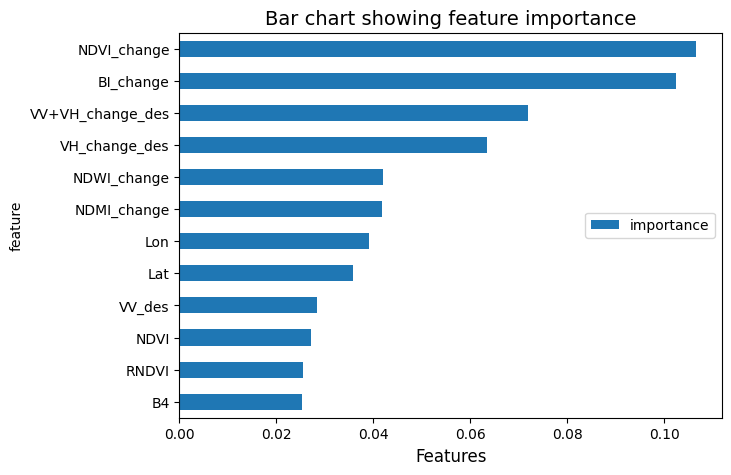

In [ ]:
impo_df = pd.DataFrame({'feature': X.columns, 'importance': xgb_par.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (7, 5))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

# Submission

In [ ]:
# Make prediction on the test set
test_df = test_data.drop(['ID', 'country'], axis = 1).fillna(0)
predictions = random_search.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID': test_data.ID, 'Target': predictions})
sub_file.head()

,ID,Target
0,ID_9ZLHTVF6NSU7,1
1,ID_LNN7BFCVEZKA,0
2,ID_SOYSG7W04UH3,1
3,ID_EAP7EXXV8ZDE,1
4,ID_QPRX1TUQVGHU,0


In [ ]:
sub_file.to_csv(path_drive + 'sub3.csv', index = False)

In [ ]:

random_search_all = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='accuracy', cv=skf.split(X,y), verbose=3, random_state=SEED )


random_search_all.fit(X, y)


y_pred_all = random_search_all.predict(X_test)
acc_score_all = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score_all)


In [ ]:
print(random_search_all.best_params_)